# Analysis VP and VN separately
## Xiaonan Wang
## 31Aug2017

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


In [130]:
def plotMA(adata, unsName, cidx=0, Cells = None, save=False, padj_cutoff=0.05, logFC_cutoff=1, exp_cutoff=-6, s=1):
    if Cells is not None:
        adata_sub = adata[Cells,:]
    else:
        adata_sub = adata
    print(adata_sub.shape)
    gnames = pd.DataFrame(adata.uns[unsName]['names']).iloc[:,cidx]
    logFC = pd.DataFrame(adata.uns[unsName]['logfoldchanges']).iloc[:,cidx]
    pvals = pd.DataFrame(adata.uns[unsName]['pvals']).iloc[:,cidx]
    padj = pd.DataFrame(adata.uns[unsName]['pvals_adj']).iloc[:,cidx]
    adata_sub = adata_sub.raw[:, gnames].X
    print(adata_sub.shape)
    normExp = np.mean(np.exp(adata_sub)-1, axis=0)
    del adata_sub
    #print(len(normExp))
    #print(len(logFC))
    abs_logFC = logFC.copy()
    abs_logFC[abs_logFC > 4] = 4
    abs_logFC[abs_logFC < -4] = -4
    #import seaborn as sns
    #sns.kdeplot(np.log(normExp))
    logExp = np.log2(normExp)
    idx = (padj < padj_cutoff) & (abs(abs_logFC) > logFC_cutoff)
    upidx = (padj < padj_cutoff) & (abs_logFC > logFC_cutoff) & (logExp > exp_cutoff)
    downidx = (padj < padj_cutoff) & (abs_logFC < -logFC_cutoff) & (logExp > exp_cutoff)
    print('upRegulated gene: '+str(sum(upidx)))
    print('downRegulated gene: '+str(sum(downidx)))
    
    fig = plt.figure()
    plt.scatter(x=logExp, y=abs_logFC, s=s)
    plt.scatter(x=logExp[idx & (logExp > exp_cutoff)], y=abs_logFC[idx & (logExp > exp_cutoff)], c='red',s=s)
    plt.axhline(y=0, color='black')
    plt.axhline(y=logFC_cutoff, color='grey', linestyle = '--')
    plt.axhline(y=-logFC_cutoff, color='grey', linestyle = '--')
    plt.axvline(x=exp_cutoff, color='grey', linestyle = '--')
    plt.xlabel('log2 Mean Exp')
    plt.ylabel('log2 Fold Change')
    plt.grid(b=None)
    plt.show()
    if save:
        fig.savefig('../figures/DEres_'+unsName+'_idx_'+str(cidx)+'.pdf')
    
    Ftable = pd.DataFrame(np.column_stack([gnames, logExp, logFC, pvals, padj]), columns=['GN','logMeanExp', 'logFC', 'pvals', 'padj'])
    return gnames[upidx], gnames[downidx], Ftable

In [3]:
%%time
Tcells_data = sc.read("Tcells_cnt.txt", cache=True, delimiter="\t")

CPU times: user 32 ms, sys: 8.92 s, total: 8.96 s
Wall time: 9.81 s


In [4]:
Tcells_data.var_names = np.genfromtxt("genes.tsv", dtype=str)[:, 1]
Tcells_data.smp_names = np.genfromtxt("Tcells_colnames.txt", dtype=str)
print(Tcells_data.smp_names[0:5])
print(Tcells_data.var_names[0:5])

['C4_AAACCTGAGATCCTGT-1' 'C4_AAACCTGAGCTGCGAA-1' 'C4_AAACCTGAGGGAGTAA-1'
 'C4_AAACCTGCACCCAGTG-1' 'C4_AAACCTGCAGGTGGAT-1']
['MIR1302-10' 'FAM138A' 'OR4F5' 'RP11-34P13.7' 'RP11-34P13.8']


In [5]:
key_labels_Tcells = np.genfromtxt('Tcells_key_labels.txt', delimiter='\t', dtype=str)
# change to proper names
key_labels_Tcells = [w.replace("C4", "D1T") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("D4", "D2T") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("E4", "D3T") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("F4", "D1S") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("G4", "D2S") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("H4", "D3S") for w in key_labels_Tcells]
key_labels_Tcells = np.array(key_labels_Tcells)
print(np.unique(key_labels_Tcells))

['A2' 'D1S' 'D1T' 'D2S' 'D2T' 'D3S' 'D3T']


In [6]:
Condition_labels = [x[-1:] for x in key_labels_Tcells]

In [7]:
for k in sorted(np.unique(key_labels_Tcells)):
    print(k)
    new_k = [k if x==k else 'others' for x in key_labels_Tcells]
    Tcells_data.smp['s'+k] = new_k
Tcells_data.smp['key_labels'] = key_labels_Tcells
Tcells_data.smp['Donor_labels'] = [x[:2] for x in key_labels_Tcells]
Tcells_data.smp['Condition_labels'] = [x[-1:] for x in key_labels_Tcells]

A2
D1S
D1T
D2S
D2T
D3S
D3T


In [8]:
mp_labels_Tcells = np.genfromtxt('Tcells_mp_labels.txt', delimiter='\t', dtype=int)
Tcells_data.smp['mp_labels'] = np.log2(mp_labels_Tcells+1)

In [9]:
VP_index = []
VN_index = []

VP_index = np.intersect1d(np.where(mp_labels_Tcells!=0)[0], np.where(key_labels_Tcells!="A2")[0])
VN_index = np.intersect1d(np.where(mp_labels_Tcells==0)[0], np.where(key_labels_Tcells!="A2")[0])

print(len(VP_index))
print(len(VN_index))

9515
31042


## VP cells

In [13]:
VP_data = Tcells_data[VP_index,]
print(VP_data.X.shape)

(9515, 32738)


### QC

In [14]:
mito_genes = np.array([name for name in VP_data.var_names if name.startswith('MT-')])
#print(np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1))
#for each cell compute fraction of counts in mito genes vs. all genes
VP_data.smp['percent_mito'] = np.sum(VP_data[:, mito_genes].X, axis=1) / np.sum(VP_data.X, axis=1)
# add the total counts per cell as sample annotation to adata
VP_data.smp['n_counts'] = np.sum(VP_data.X, axis=1)
VP_data.smp['log2_n_counts'] = np.log2(np.sum(VP_data.X, axis=1))
VP_data.smp['n_genes'] = (VP_data.X!=0).astype(int).sum(axis=1)

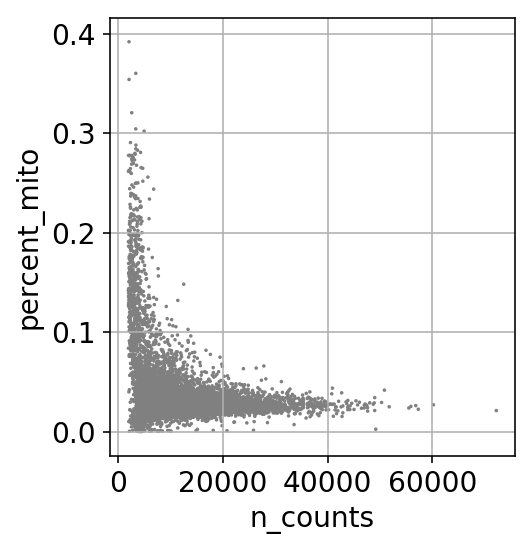

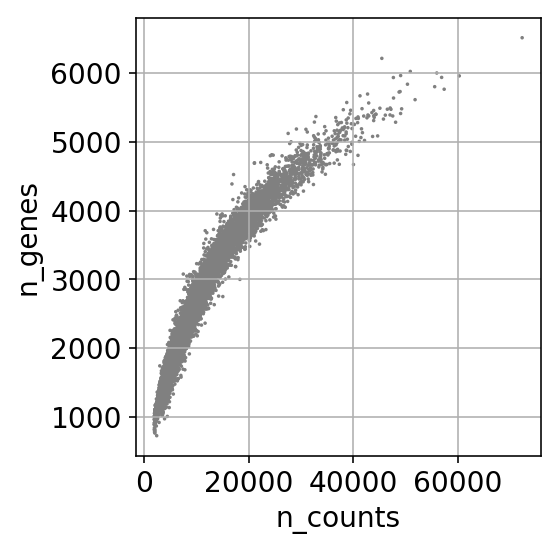

In [15]:
axs = sc.pl.scatter(VP_data, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(VP_data, x='n_counts', y='n_genes')

In [16]:
sc.pp.filter_genes(VP_data, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(VP_data)          # normalize with total UMI count per cell

### Select HVGs

In [17]:
%%time
filter_result_VP = sc.pp.filter_genes_dispersion(VP_data.X, flavor='cell_ranger', n_top_genes=1000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 6.40 GB, difference +6.40 GB
CPU times: user 1.04 s, sys: 484 ms, total: 1.53 s
Wall time: 1.53 s


/home/USSR/xw251/anaconda2/envs/mypython3/lib/python3.6/site-packages/matplotlib/scale.py:103: RuntimeWarning: divide by zero encountered in log
  return np.divide(np.log(a, out=a), np.log(self.base), out=a)


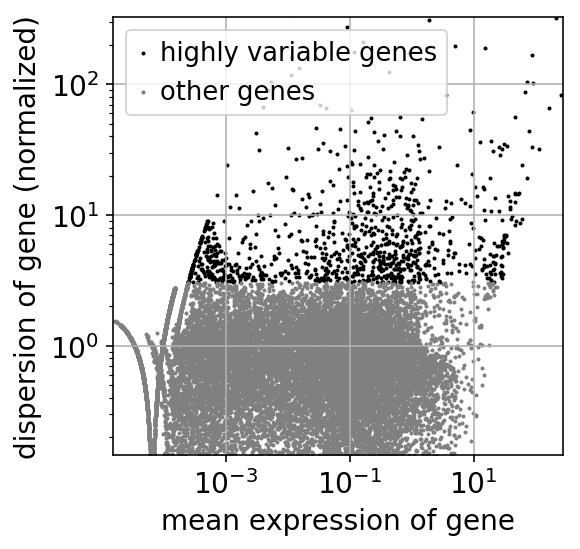

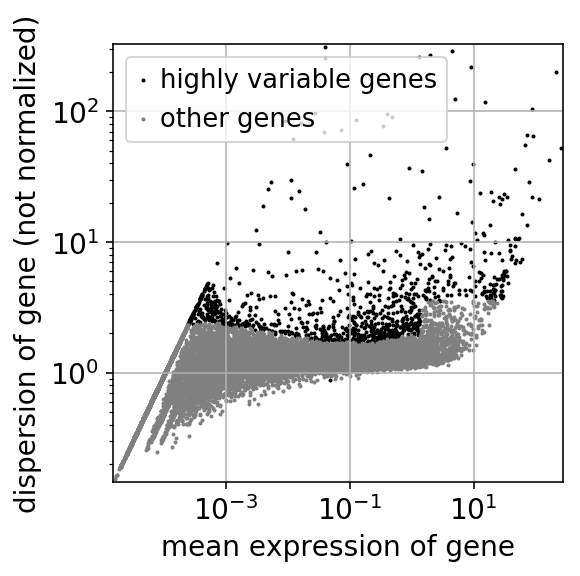

In [18]:
sc.pl.filter_genes_dispersion(filter_result_VP, log=True)

In [19]:
VP_data = VP_data[:, filter_result_VP.gene_subset] 

In [20]:
%%time
sc.pp.log1p(VP_data)
VP_data_corrected = sc.pp.regress_out(VP_data, ['n_counts', 'percent_mito'], copy=True)
sc.pp.scale(VP_data_corrected)
sc.logging.print_memory_usage()


Memory usage: current 5.78 GB, difference -0.62 GB
CPU times: user 59.9 s, sys: 2.01 s, total: 1min 1s
Wall time: 1min 18s


### PCA

In [21]:
%%time
sc.tl.pca(VP_data_corrected, n_comps=50)
sc.logging.print_memory_usage()

Memory usage: current 5.82 GB, difference +0.04 GB
CPU times: user 30.2 s, sys: 1.06 s, total: 31.2 s
Wall time: 5.15 s


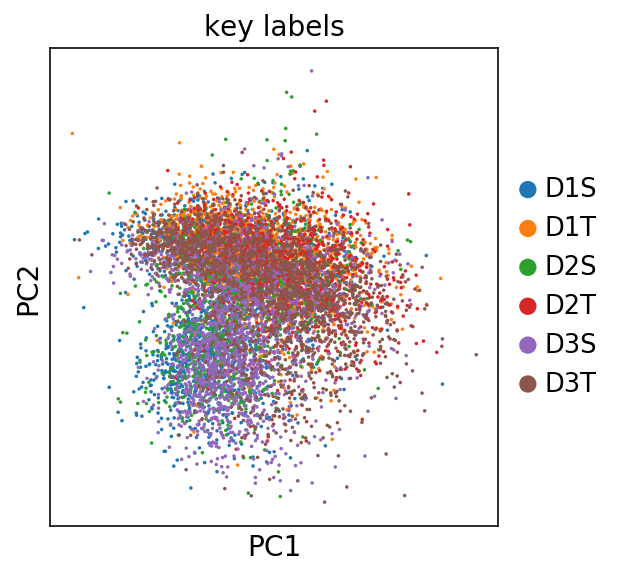

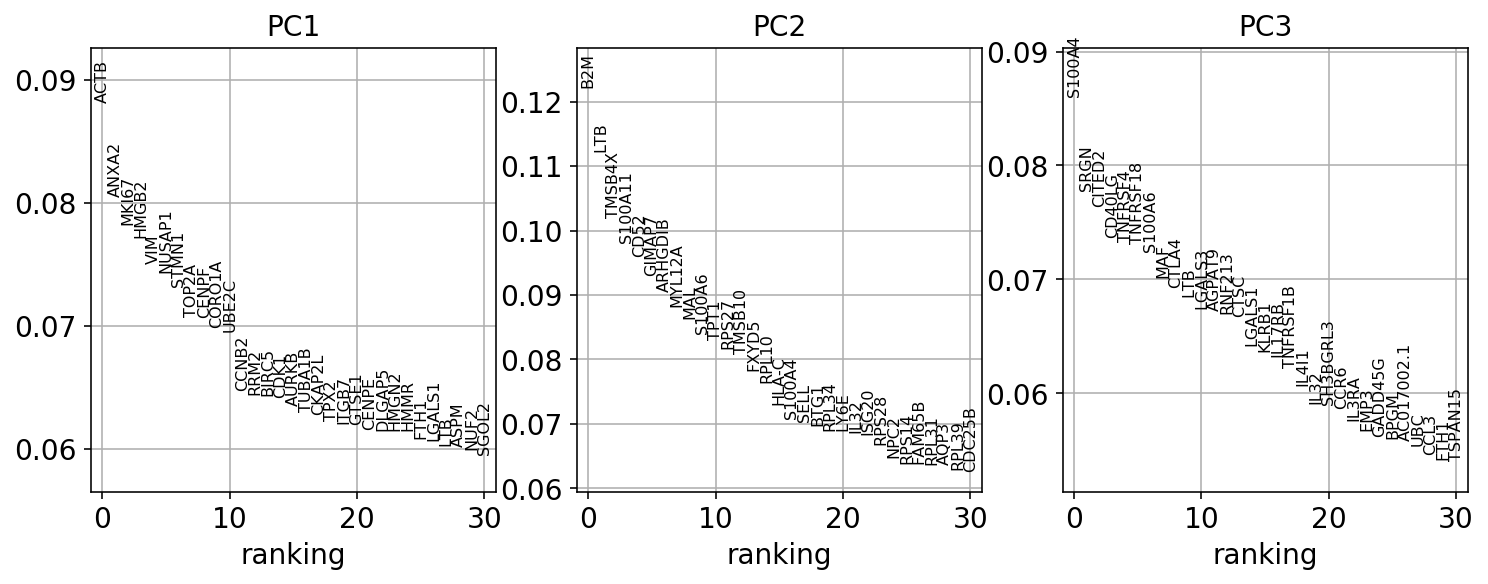

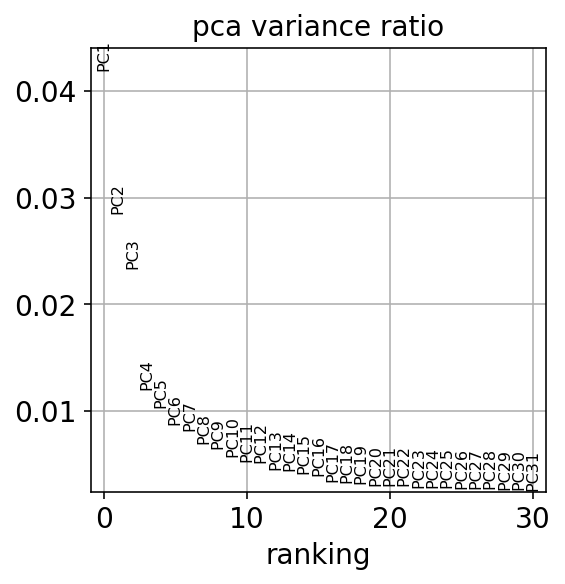

In [22]:
sc.pl.pca(VP_data_corrected, components= '1,2', color='key_labels')

### TSNE

In [23]:
%%time
sc.tl.tsne(VP_data_corrected,n_jobs=40)
sc.logging.print_memory_usage()

Memory usage: current 5.84 GB, difference +0.02 GB
CPU times: user 8min 59s, sys: 18min 24s, total: 27min 24s
Wall time: 42.6 s


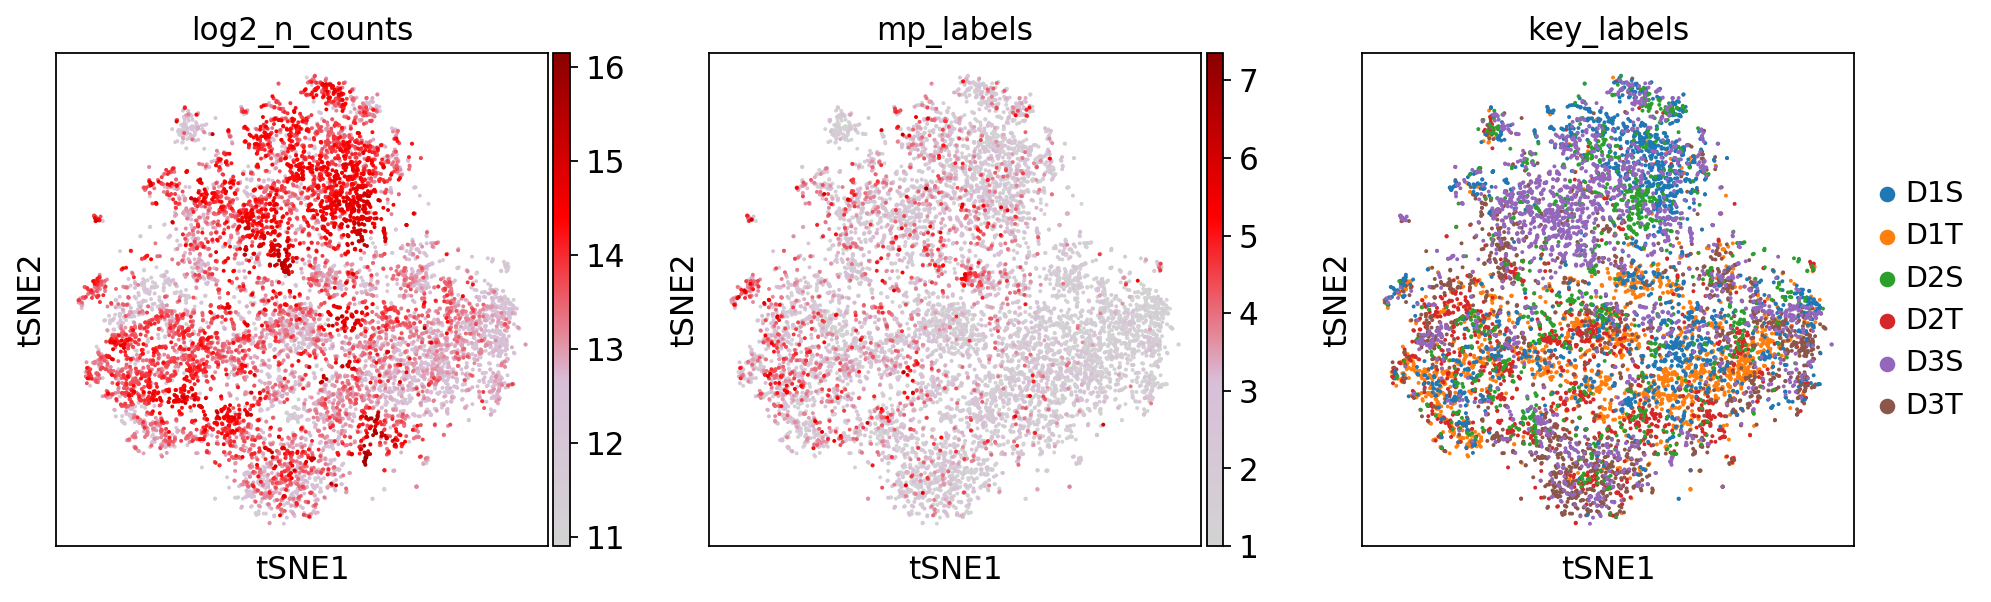

In [25]:
ax = sc.pl.tsne(VP_data_corrected, color=['log2_n_counts', 'mp_labels', 'key_labels'], legend_loc='right margin', color_map=cmap)

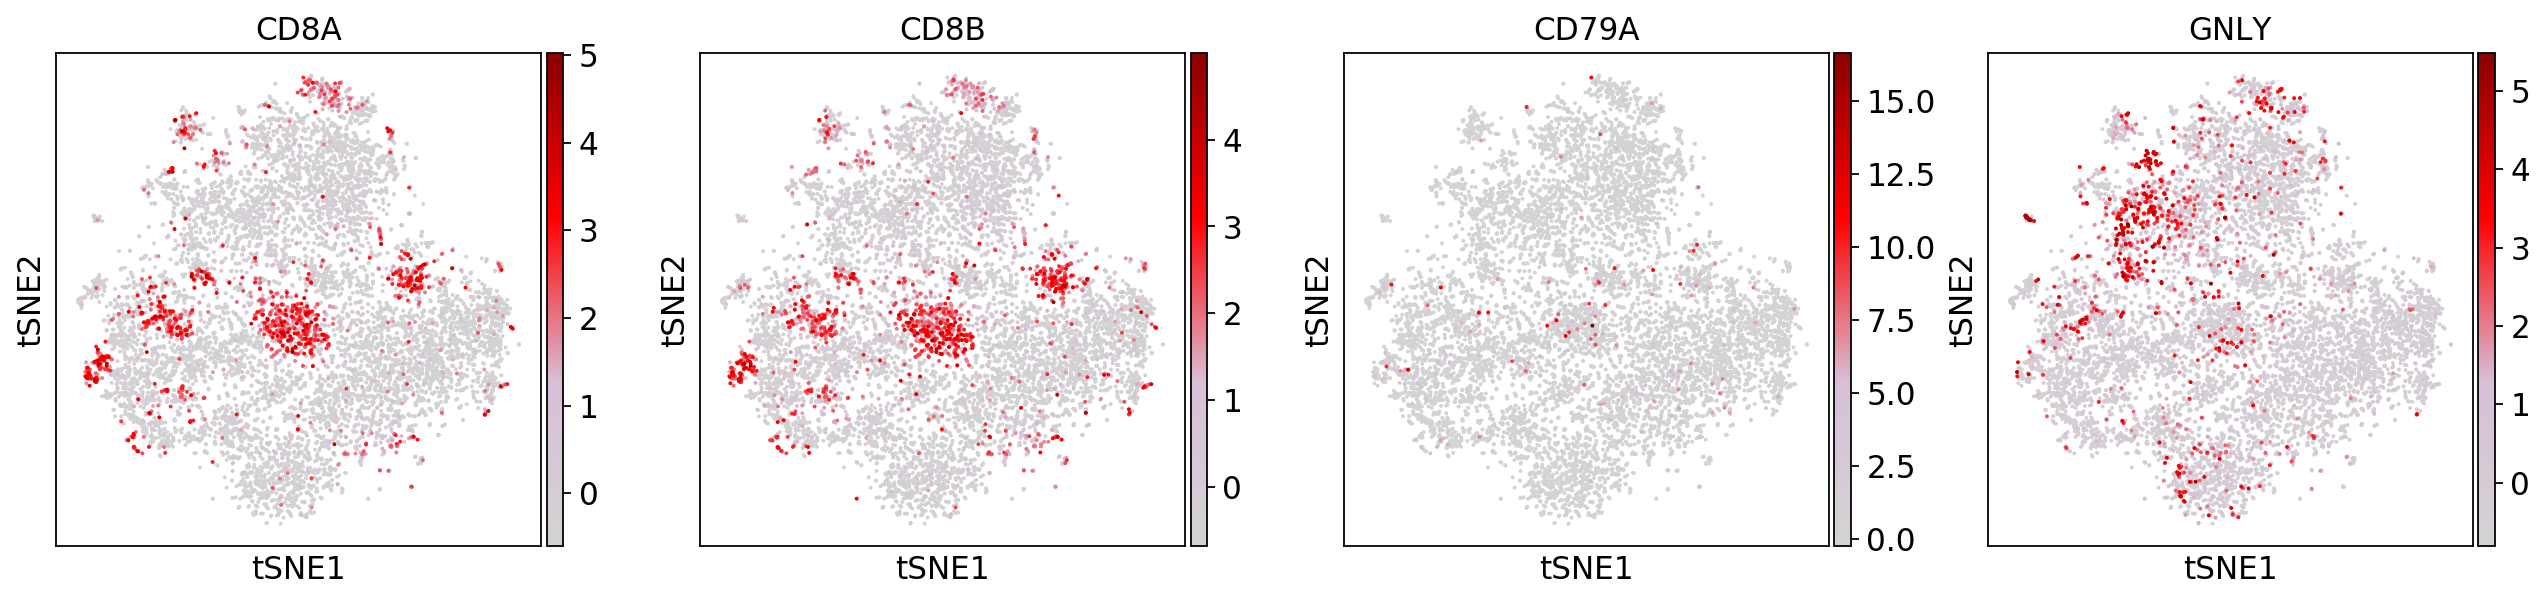

In [27]:
axs = sc.pl.tsne(VP_data_corrected, color=['CD8A', 'CD8B', 'CD79A', 'GNLY'], legend_loc='right margin', legend_fontsize=10, color_map=cmap)

### Louvain clustering

In [4]:
%%time
sc.tl.louvain(VP_data_corrected, n_jobs=40, resolution=0.4) # 0.5
sc.logging.print_memory_usage()

Memory usage: current 0.30 GB, difference +0.30 GB
CPU times: user 11.2 s, sys: 32 ms, total: 11.2 s
Wall time: 11.2 s


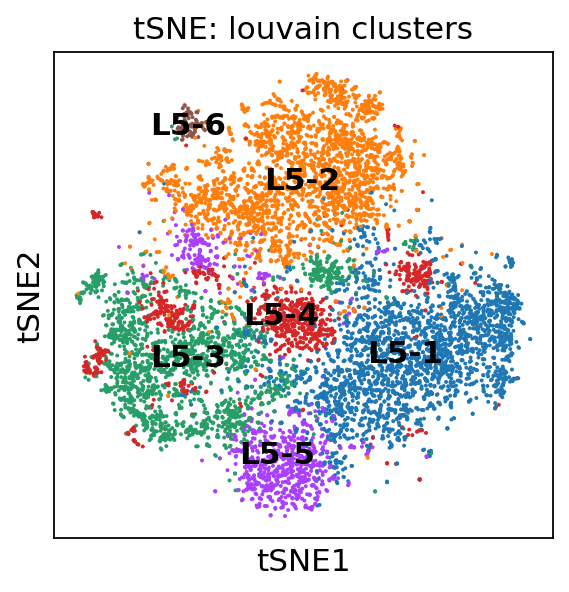

In [8]:
ax = sc.pl.tsne(VP_data, color=['Louvain_Clusters'], legend_loc='on data', title='tSNE: louvain clusters')

### DE analysis1

In [62]:
VP_data = sc.read('../write_new/VP_corrected.h5ad', cache=True)

In [64]:
temp = VP_data[VP_data.obs['Condition'] == 'Stimulated',:].copy()

In [65]:
sc.tl.rank_genes_groups(temp, 'Louvain_Clusters', n_genes=temp.raw.shape[1], key_added='DE_cluster')

ranking genes
    finished: added to `.uns['DE_cluster']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:58)


In [66]:
pd.DataFrame(temp.uns['DE_cluster']['names']).head(10)

L5-1      L5-2     L5-3     L5-4    L5-5   L5-6
0    RPL10     ZBED2    STMN1     CTSW  S100A4  RPL31
1     TPT1  HSP90AB1    HMGB2     CD8A     LTB   GZMA
2    RPS27     FABP5    HMGN2     NKG7    EMP3   PFN1
3      B2M      NPM1   NUSAP1     CD8B   OSTF1   CCL3
4      LTB      NME1  ARHGDIB     GZMA  RNF213   GZMB
5    RPL34       SRM    MKI67    COTL1  S100A6  ACTG1
6    RPS14     IL2RA    CENPF  ALOX5AP   ANXA2  ALDOA
7   GIMAP7     HSPD1    H2AFV     HCST   ITGB7   CD8A
8    RPS28     HSPE1     SMC4     HOPX    CTSH   PTMA
9  PTPRCAP    SERBP1  CARHSP1     ABI3  LGALS1  RPL21

(4663, 999)
(4663, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 158
downRegulated gene: 1176


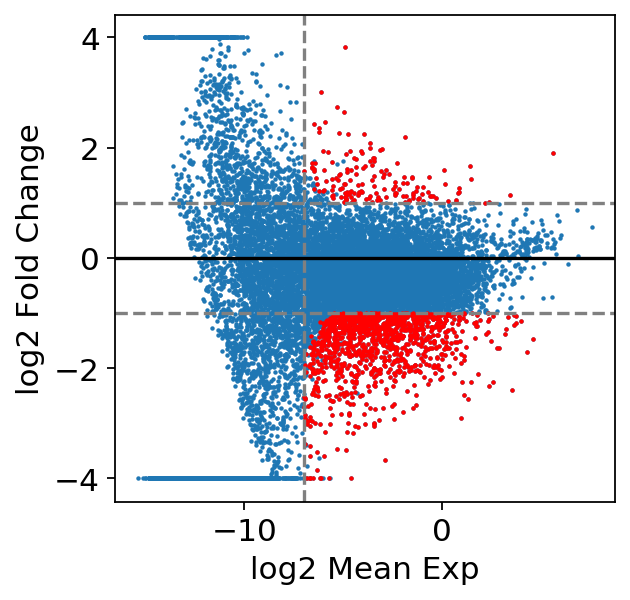

(4663, 999)
(4663, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 953
downRegulated gene: 534


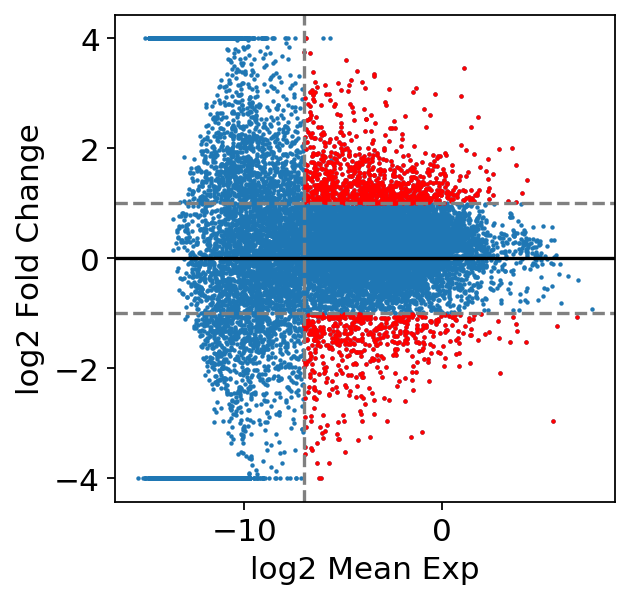

(4663, 999)
(4663, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 281
downRegulated gene: 405


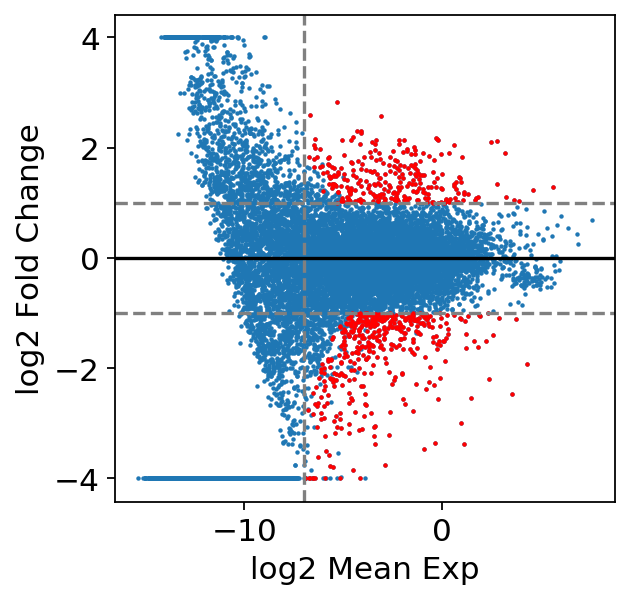

(4663, 999)
(4663, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 154
downRegulated gene: 127


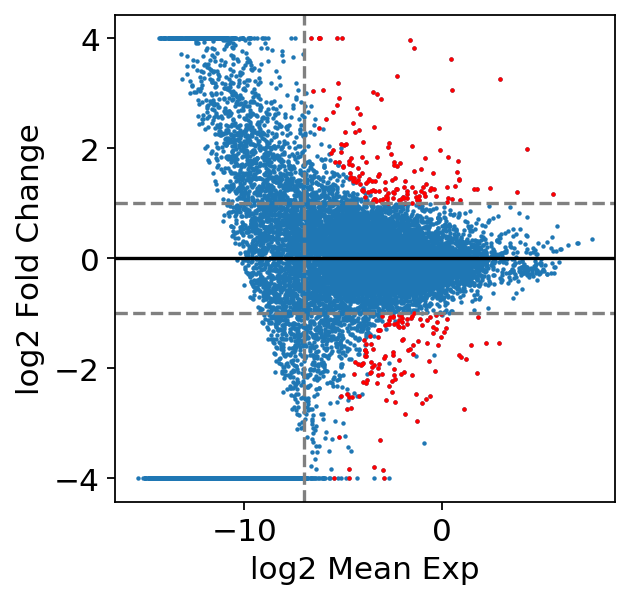

(4663, 999)
(4663, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 297
downRegulated gene: 448


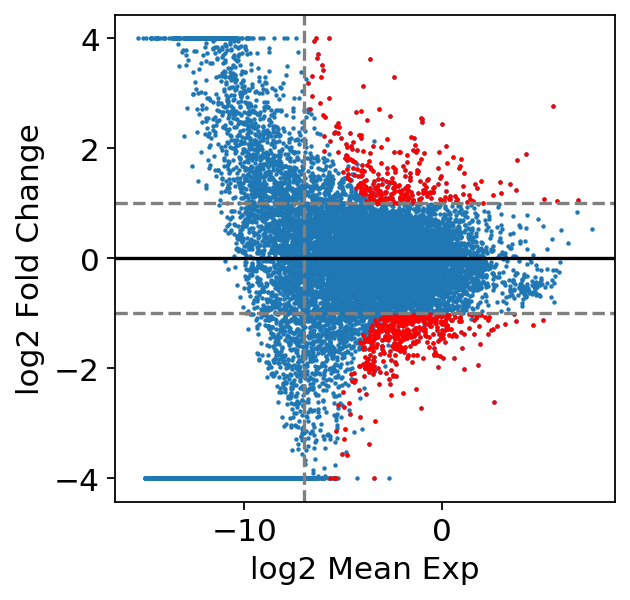

(4663, 999)
(4663, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 3
downRegulated gene: 15


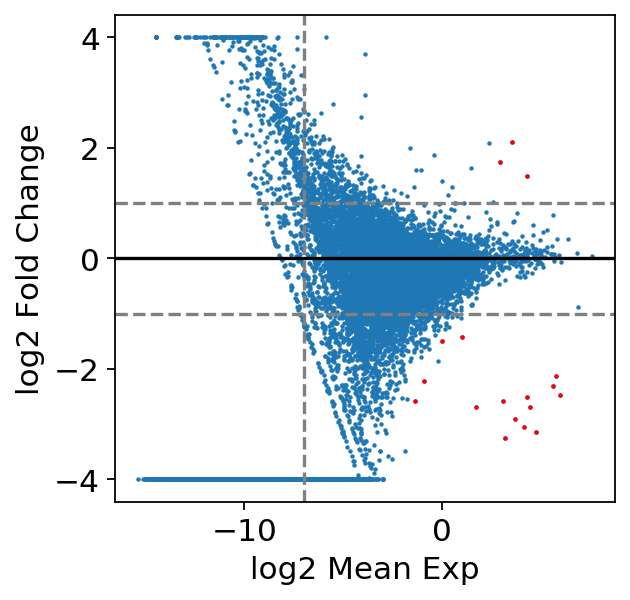

In [152]:
for idx,cl in enumerate(temp.obs['Louvain_Clusters'].cat.categories):
    upG, downG, tableG = plotMA(temp, 'DE_cluster',save=True, cidx=idx, padj_cutoff=0.05, logFC_cutoff=1, exp_cutoff=-7)
    np.savetxt('../DEres/VP_Sti_cluster/c'+cl+'vsAll_upG.txt', upG, delimiter='\t', fmt='%s')
    np.savetxt('../DEres/VP_Sti_cluster/c'+cl+'vsAll_downG.txt', downG, delimiter='\t', fmt='%s')
    tableG.to_csv('../DEres/VP_Sti_cluster/c'+cl+'vsAll_table.csv')

In [22]:
# Generate pre-ranked list for GSEA for stimulated only
L5_2tab = pd.read_csv('../DEres/VP_Sti_cluster/cL5-2vsAll_table.csv', index_col=0)
mod_padj = L5_2tab['padj'].values
mod_padj[mod_padj == 0] = np.min(mod_padj[mod_padj != 0])
mod_padj = mod_padj**(0.01)
print(min(mod_padj))
print(max(mod_padj))
L5_2tab['score'] = (1/mod_padj)*np.sign(L5_2tab['logFC'])
L5_2tab[['GN', 'score']].to_csv('L5_2_sti_ranked_ori.rnk', sep='\t', header=False, index=False)

0.0009017410983908432
1.0


In [10]:
VP_data.write('../write_new/VP_corrected.h5ad')

In [1]:
## Must load this first before scanpy to avoid issues
%load_ext rpy2.ipython

In [71]:
L5_2tab = pd.read_csv('../DEres/VP_Sti_cluster/cL5-2vsAll_table.csv', index_col=0)

In [73]:
%%R -i L5_2tab
## Calculate enriched terms using hypergeometric test
require("ggplot2")
require("ggrepel")

pval <- function(g.list, genes, db_path){
  dbList <- readLines(db_path)
  pval <- do.call("rbind", lapply(dbList, function(x){
    g.set <- strsplit(x, split="\t")[[1]]
    g.label <- g.set[1]
    g.set <- g.set[-(1:2)]
    #print(g.label)
    #print(length(g.set))
    sn <- length(intersect(genes, g.set))
    if (sn >= 5 & sn <= 500){
      p <- phyper(length(intersect(g.list, g.set))-1, sn, length(genes)-length(g.set), length(g.list), lower.tail = F) 
      per.p <- replicate(100, phyper(length(intersect(g.list, sample(genes, sn)))-1, length(g.set), length(genes)-length(g.set), length(g.list), lower.tail = F))
      per.p.ave <- mean(per.p)
      k = length(intersect(g.list, g.set))
      d <- data.frame(Term=g.label, k=k, k_Kratio=k/sn,p=p, per.p=per.p.ave)
      return(d)
    }
  }))
  return(pval)
}

g.list = read.csv('../DEres/VP_Sti_cluster/cL5-2vsAll_upG.txt')[,1]
ptab = pval(g.list, L5_2tab$GN, '../c2.cp.pid.v7.0.symbols.gmt')
ptab$qval = p.adjust(ptab$p, method="BH")
ptab = ptab[order(ptab$qval),]
write.csv(ptab, "L5_2_hypertab_c2_PID.csv",row.names=F)

In [155]:
%%R 
# Ignore this Fernando does not like it
require("qusage")
require("ggplot2")
require("ggrepel")

tab = read.table('L5_2_hypertab_c2_PID.csv', sep=',', header=T)
db = read.gmt('../c2.cp.pid.v7.0.symbols.gmt')
print(dim(tab))
upG = read.csv('../DEres/VP_Sti_cluster/cL5-2vsAll_upG.txt', header=F)[,1]
downG = read.csv('../DEres/VP_Sti_cluster/cL5-2vsAll_downG.txt', header=F)[,1]

qval_cutoff = 0.05
freqFC = unlist(lapply(tab[,1], function(x){
    overlapUP = length(intersect(upG, db[[match(x, names(db))]]))
    overlapDOWN = length(intersect(downG, db[[match(x, names(db))]]))
    freqpn = (overlapUP+1)/(overlapDOWN+1)
    return(freqpn)
}))
Term = gsub("PID_(.*)PATHWAY", "\\1", tab[,1])
Term = gsub("(.*)_$", "\\1", Term)
Ftab = data.frame(Term=Term, qval=-log2(tab[,6]), Num_Genes=tab[,2], UpDown_Ratio=log2(freqFC), Overlap_Ratio=tab[,3])
                    
p <- ggplot(Ftab, aes(x=UpDown_Ratio, y=qval))+geom_point(aes(size=Num_Genes, color=Overlap_Ratio))
p <- p + scale_colour_gradient2(low='grey', mid='red', high='dark red',midpoint=0.25)
p <- p + ylab('-log2 qval')
p <- p + xlab('log2 UpDown_Ratio')
p <- p + geom_text_repel(data=subset(Ftab, qval > -log2(qval_cutoff) & UpDown_Ratio > 1),
                         aes(label=Term)
)
p <- p + theme_bw() + theme(plot.background = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank())
p <- p + geom_hline(yintercept = -log2(qval_cutoff),linetype = "dashed", color='grey')
p <- p + geom_vline(xintercept = 1,linetype = "dashed", color='grey')
p
ggsave("./figures/VP_Immo_anno_new.pdf", width=8, height=6, useDingbats = FALSE)

[1] 196   6


## VN cells

In [47]:
VN_data = Tcells_data[VN_index,]
print(VN_data.X.shape)

(31042, 32738)


### QC

In [48]:
mito_genes = np.array([name for name in VN_data.var_names if name.startswith('MT-')])
#print(np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1))
#for each cell compute fraction of counts in mito genes vs. all genes
VN_data.smp['percent_mito'] = np.sum(VN_data[:, mito_genes].X, axis=1) / np.sum(VN_data.X, axis=1)
# add the total counts per cell as sample annotation to adata
VN_data.smp['n_counts'] = np.sum(VN_data.X, axis=1)
VN_data.smp['log2_n_counts'] = np.log2(np.sum(VN_data.X, axis=1))
VN_data.smp['n_genes'] = (VN_data.X!=0).astype(int).sum(axis=1)

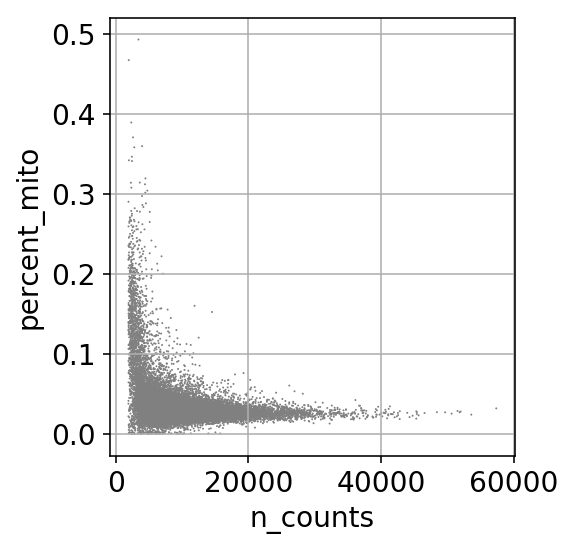

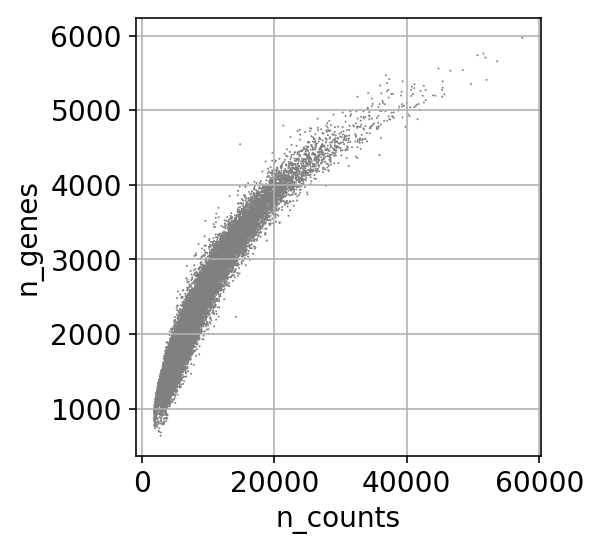

In [56]:
axs = sc.pl.scatter(VN_data, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(VN_data, x='n_counts', y='n_genes')

In [49]:
sc.pp.filter_genes(VN_data, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(VN_data)          # normalize with total UMI count per cell

### Select HVGs

In [50]:
%%time
filter_result_VN = sc.pp.filter_genes_dispersion(VN_data.X, flavor='cell_ranger', n_top_genes=1000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 21.17 GB, difference +21.17 GB
CPU times: user 2.78 s, sys: 1.72 s, total: 4.5 s
Wall time: 4.5 s


/home/USSR/xw251/anaconda2/envs/mypython3/lib/python3.6/site-packages/matplotlib/scale.py:103: RuntimeWarning: divide by zero encountered in log
  return np.divide(np.log(a, out=a), np.log(self.base), out=a)


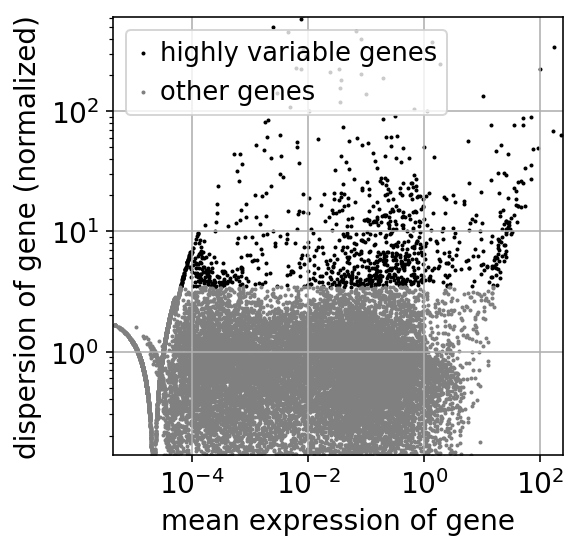

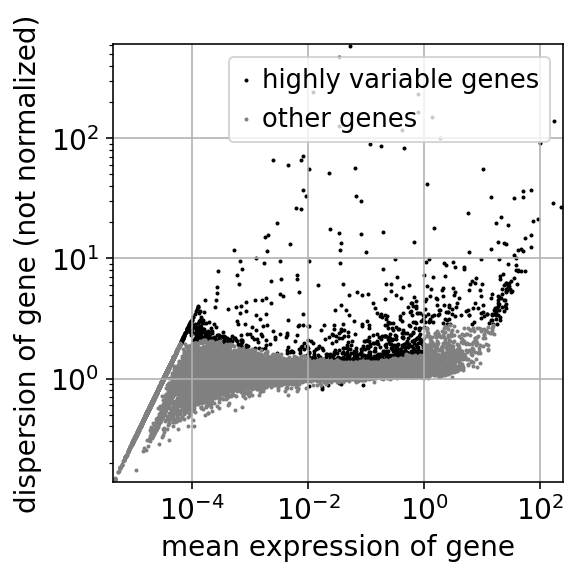

In [51]:
sc.pl.filter_genes_dispersion(filter_result_VN, log=True)

In [52]:
VN_data = VN_data[:, filter_result_VN.gene_subset] 

In [61]:
%%time
sc.pp.log1p(VN_data)
VN_data_corrected = sc.pp.regress_out(VN_data, ['n_counts', 'percent_mito'], copy=True)
sc.pp.scale(VN_data_corrected)
sc.logging.print_memory_usage()


Memory usage: current 13.24 GB, difference -2.16 GB
CPU times: user 4min 5s, sys: 5.56 s, total: 4min 11s
Wall time: 4min 11s


### PCA

In [62]:
%%time
sc.tl.pca(VN_data_corrected, n_comps=50)
sc.logging.print_memory_usage()

Memory usage: current 13.30 GB, difference +0.05 GB
CPU times: user 1min 30s, sys: 3.08 s, total: 1min 33s
Wall time: 14.4 s


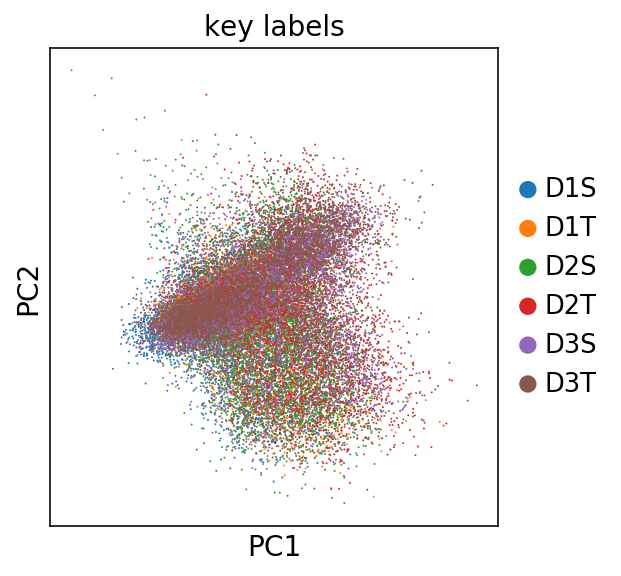

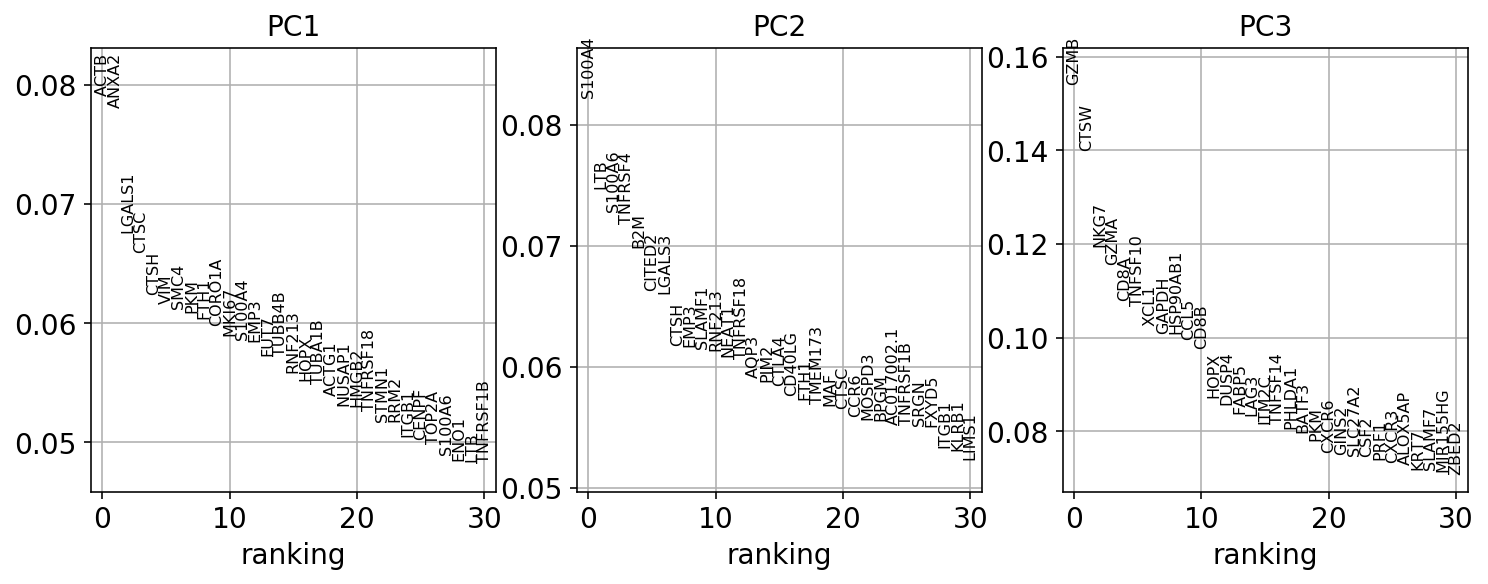

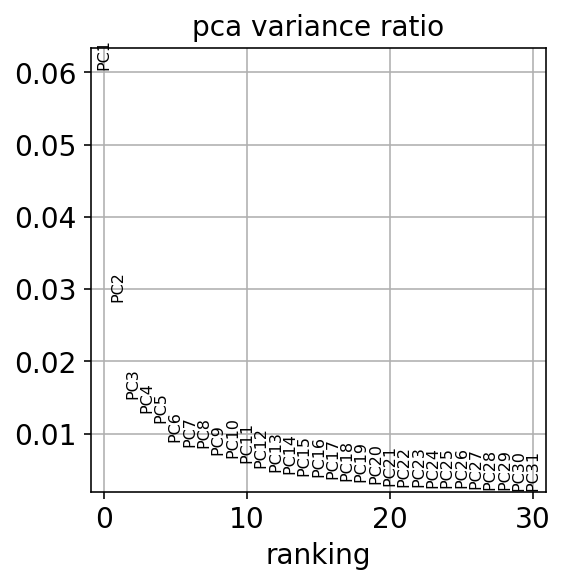

In [63]:
sc.pl.pca(VN_data_corrected, components= '1,2', color='key_labels')

### TSNE

In [64]:
%%time
sc.tl.tsne(VN_data_corrected,n_jobs=40)
sc.logging.print_memory_usage()

Memory usage: current 13.32 GB, difference +0.02 GB
CPU times: user 30min 29s, sys: 1h 2min 16s, total: 1h 32min 46s
Wall time: 2min 35s


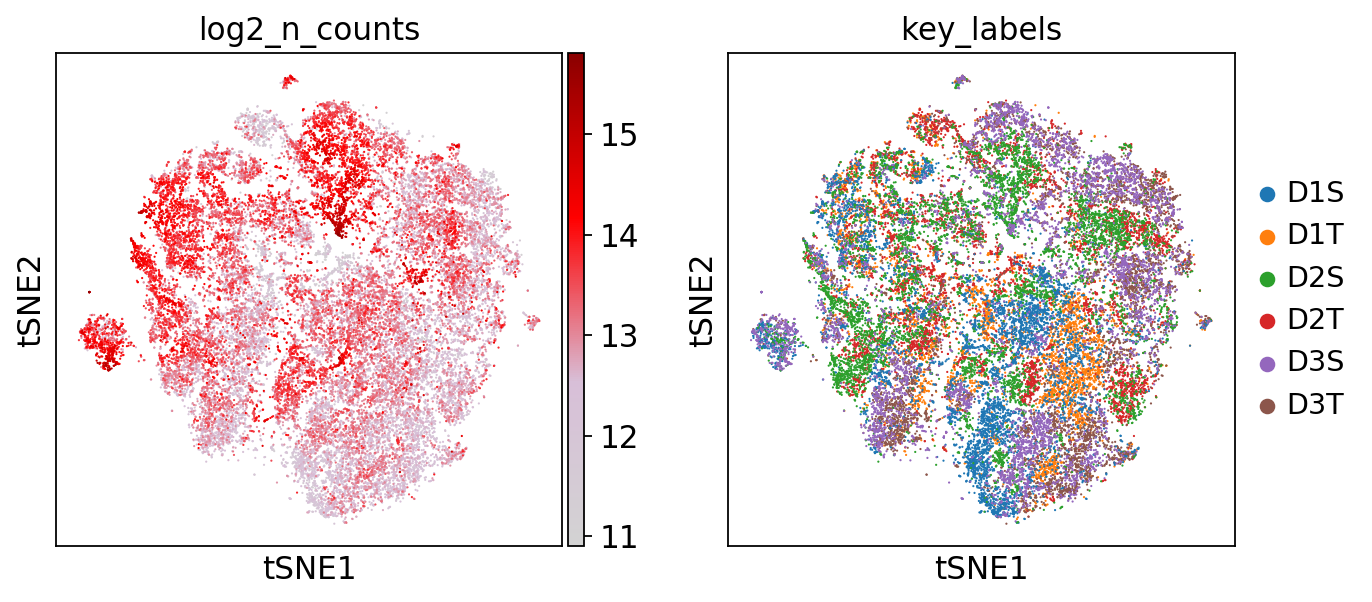

In [38]:
ax = sc.pl.tsne(VN_data_corrected, color=['log2_n_counts','key_labels'], legend_loc='right margin', color_map=cmap)

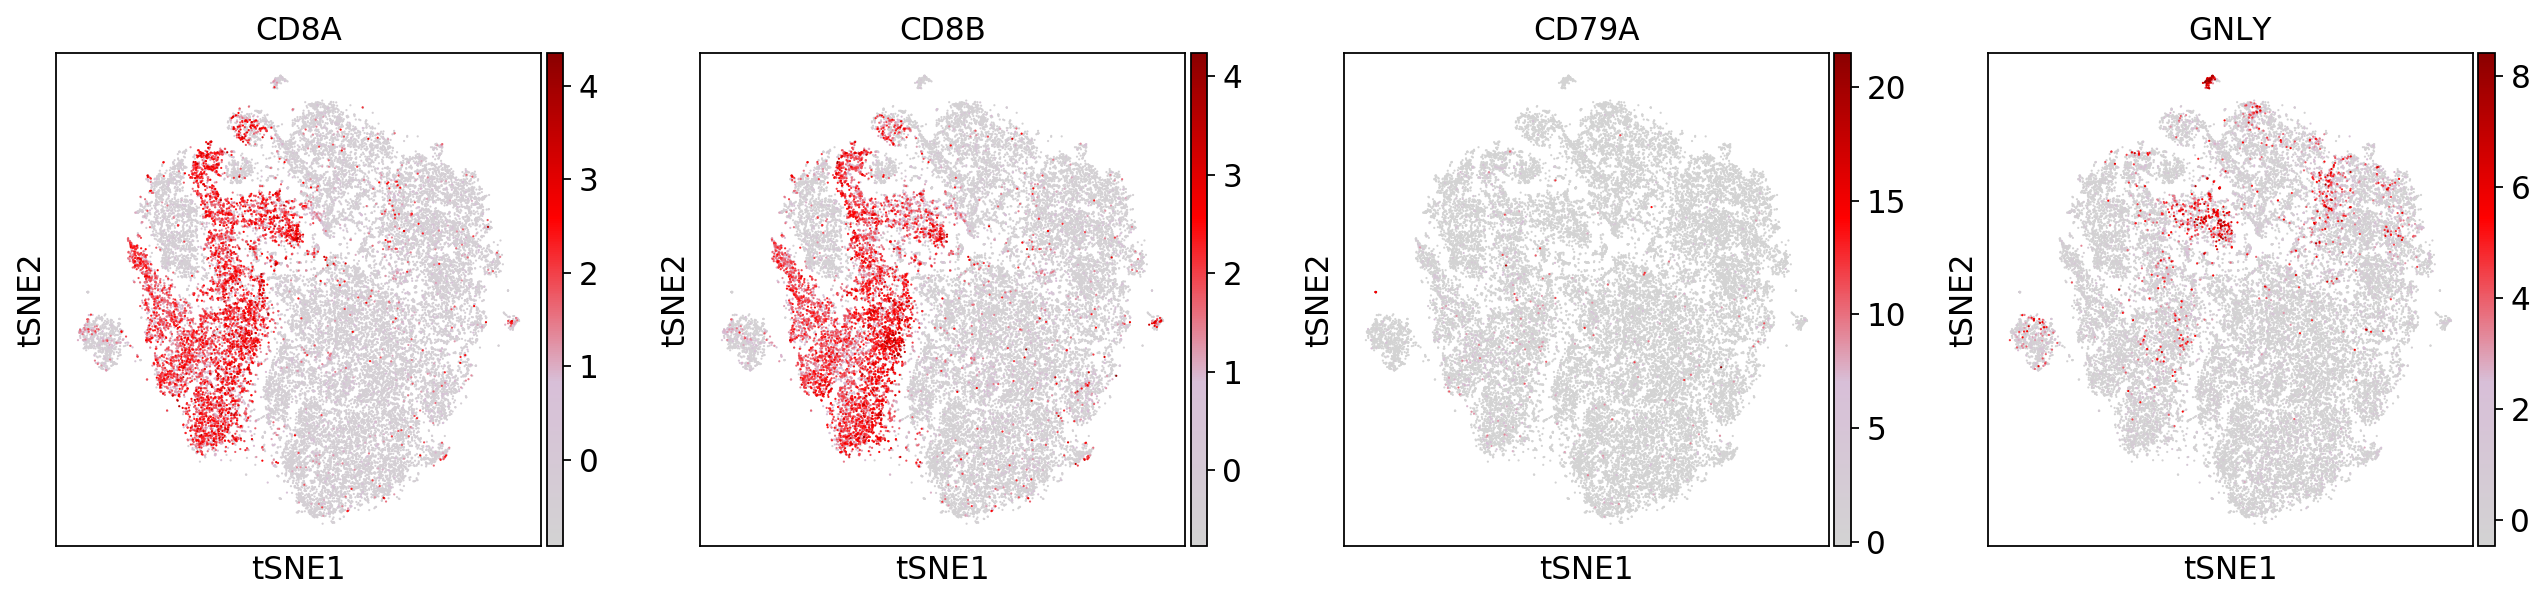

In [39]:
axs = sc.pl.tsne(VN_data_corrected, color=['CD8A', 'CD8B', 'CD79A', 'GNLY'], legend_loc='right margin', legend_fontsize=10, color_map=cmap)

### Louvain clustering

In [8]:
VN_data_corrected = sc.read('VN_corrected')

In [9]:
%%time
sc.tl.louvain(VN_data_corrected, n_jobs=40, resolution=0.4) # 0.5
sc.logging.print_memory_usage()

Memory usage: current 0.49 GB, difference +0.19 GB
CPU times: user 38.2 s, sys: 220 ms, total: 38.4 s
Wall time: 38.4 s


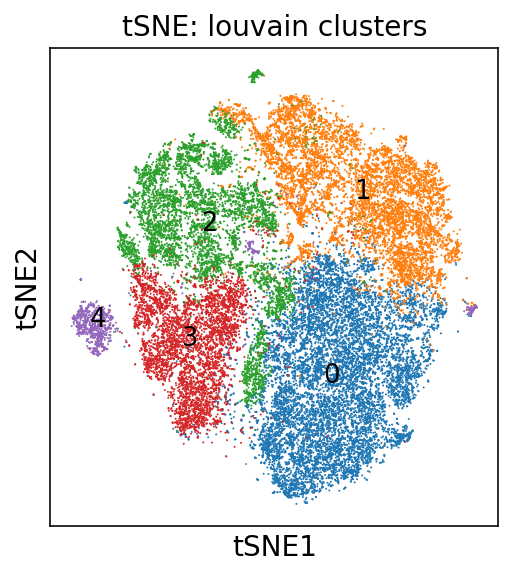

In [10]:
ax = sc.pl.tsne(VN_data_corrected, color=['louvain_groups'], legend_loc='on data', title='tSNE: louvain clusters')

## Save objects

In [40]:
VN_data_corrected.uns['DE_louvain'] = VN_nor.uns['rank_genes_groups']
VP_data_corrected.uns['DE_louvain'] = VP_nor.uns['rank_genes_groups']

VN_data_corrected.write('./write/VN_corrected.h5')
VP_data_corrected.write('./write/VP_corrected.h5')